In [9]:
import rasterio, os

# import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd 
import xarray as xr
import rioxarray as rx
import geopandas as gpd
import matplotlib.pyplot as plt
from temporal_curve import temporal_curve_24hr
from pathlib import Path

%matplotlib inline


In [10]:
# Only Buffer Polygons along coastline without overlapping regions of neighbouring boundaries
# https://gis.stackexchange.com/questions/434355/buffer-polygons-without-overlapping-regions-of-neighbouring-boundaries-in-arcgis
# 
# 1. Buffer the boundary shapefile with dissolve type= all, i.e. bf = 10km
#  Because The NZClimate shapefile's projection is WGS84, I reproject it to NZTM before buffering. 
#  Boundary shapefile in WGS84 - E:\Tuflow\Cal_rainfall_timeseries\data\NZ_ClimateZone\NZClimate.shp
#  Boundary shapefile in NZTM  - E:\Tuflow\Cal_rainfall_timeseries\data\NZ_ClimateZone\NZClimate_NZTM.shp
#  Buffered shapefile          - temporary file, NZClimate_pro_bf10km
# 
# 2. Calculate the Euclidean Allocation of the original boundary shapefile, and set up Euclidean Allocation tool as below
#  2.1   calculate the Euclidean Allocation by the 'id' field, i.e. the 'FID' filed of NZClimate_NZTM.shp
#  2.2   the maximum distance is set to the buffer distance used in step 1, i.e.  maximum distance = 10km
#  2.3   use the buffered shapefile's extent in environment setting when processing 
#  2.4   set the output cellsize to a small value, i.e. output cellsize = 10m
#  output raster in NZTM  - temporary file, EucAllo_NZCl5
# 
# 3. Convert the raster output in step 2 to polygons 
#  output polygon in NZTM - E:\Tuflow\Cal_rainfall_timeseries\data\NZ_ClimateZone\NZClimate_bf10km_NZTM.shp
# 
# 4. Project the new polygons to WGS84
#  Projected polygon in WGS84 - E:\Tuflow\Cal_rainfall_timeseries\data\NZ_ClimateZone\NZClimate_bf10km.shp




In [11]:
# # Get the regional temporal curve by NZClimate zone

In [12]:
ARI = 500 #250

In [13]:
# Region polygon shapefile
gdf_Pilbara = gpd.read_file('/home/lusun/LuSUN/Data/riotinto_mash/catchment_boundary/watershed_WGS84_without_offshore_islands_filledholes_dissolved.shp')
gdf_Pilbara

,id,geometry
0,1,"POLYGON ((118.74750 -20.29250, 118.74750 -20.3..."


In [14]:
data_dir=  Path("/home/lusun/LuSUN/Data/riotinto_mash")
chunks = {'time':-1}
precip_files = list(sorted(data_dir.joinpath("all_durations").glob("*Precipitation*.nc4")))
base_data  = xr.open_mfdataset(precip_files, 
                            # engine='h5netcdf',
                            #engine='netcdf4',
                            # preprocess=preprocess, 
                            chunks=chunks)#.prec.sel(time=slice("1991","2020")) #"1991", '2020'

base_data = base_data.sel(ari=ARI).drop(["ari"]).rename({"lat": "latitude", "lon":"longitude"})
base_data .rio.write_crs("epsg:4326", inplace=True)
base_data 


<xarray.Dataset>
Dimensions:                (hrs: 29, latitude: 1361, longitude: 1761)
Coordinates:
  * latitude               (latitude) float64 -9.787 -9.812 ... -43.76 -43.79
  * longitude              (longitude) float64 110.4 110.4 110.4 ... 154.4 154.4
  * hrs                    (hrs) float64 0.02 0.03 0.05 ... 120.0 144.0 168.0
    spatial_ref            int64 0
Data variables:
    Extreme_Precipitation  (hrs, latitude, longitude) float32 dask.array<chunksize=(1, 1361, 1761), meta=np.ndarray>
Attributes:
    units:       mm
    regenerate:  http://www.climsystems.com J.Yu 2023-07-03
    source:      Australia Govemment Bureau of Meteorology Design Rainfall Da...

In [18]:
dataset = xr.open_mfdataset(precip_files, chunks=chunks)
variable_names = list(dataset.variables)
variable_names


['Extreme_Precipitation', 'lat', 'lon', 'hrs', 'ari']

In [20]:
for var_name in ['ari', 'hrs']:
    var_values = dataset[var_name].values
    print(f"Variable: {var_name}")
    print(f"Values: {var_values}")
    print()

Variable: ari
Values: [   2    3    5   10   20   50  100  200  500 1000 2000]

Variable: hrs
Values: [2.00e-02 3.00e-02 5.00e-02 7.00e-02 8.00e-02 1.70e-01 2.50e-01 3.30e-01
 4.20e-01 5.00e-01 7.50e-01 1.00e+00 1.50e+00 2.00e+00 3.00e+00 4.50e+00
 6.00e+00 9.00e+00 1.20e+01 1.80e+01 2.40e+01 3.00e+01 3.60e+01 4.80e+01
 7.20e+01 9.60e+01 1.20e+02 1.44e+02 1.68e+02]



In [21]:
# Calculate the regional curve by NZClimate zones
pdfs_df = pd.DataFrame()
cdfs_df = pd.DataFrame()
ddfs_region = pd.DataFrame()


for i in gdf_Pilbara.index:
    
    gdf = gdf_Pilbara.iloc[[i]]
    # FID = i
    region_name = 'Pilbara'
    
    da_auk = base_data.rio.clip(gdf.geometry.values, gdf.crs)
    da_auk_m = da_auk.mean(dim=['latitude', "longitude"]).drop("spatial_ref")

    # to dataframe
    df_ddfs = da_auk_m.to_dataframe().rename({"Extreme_Precipitation" : "ddf"}, axis=1)

    # convert duration from hours to minutes
    df_ddfs.index = np.round(df_ddfs.index*60, 4)
    df_ddfs.index.name = "mins"
    
    # Calculate temporal curve
    df_crrs_auk_m = temporal_curve_24hr(df_ddfs)
    
    # Convert CDF to PDF
    crrs_cdf_series = df_crrs_auk_m['crr']
    crrs_pdf_series = df_crrs_auk_m['crr'].diff().fillna(df_crrs_auk_m['crr'][0])
    
    # cdf_series = df_crrs_auk_m * df_ddfs.loc[1440].values 
    # pdf_series = cdf_series['crr'].diff().fillna(cdf_series['crr'][0])
    # # pdf_df = pd.DataFrame({region_name: pdf_series})
    
    print(region_name)
    pdfs_df[region_name] = crrs_pdf_series
    cdfs_df[region_name] = crrs_cdf_series
    ddfs_region[region_name] = df_ddfs
    
    
out_path = '/home/lusun/LuSUN/output/'
if not os.path.exists(out_path):
    os.makedirs(out_path)
    
out_file = out_path + 'baseline_regional_pdfs_ARI' + str(ARI) + '_byPilbaraClimate.csv'
pdfs_df.to_csv(out_file, index=True, header=True, float_format='%.8f')

out_file2 = out_path + 'baseline_regional_ddfs_ARI' + str(ARI) + '_byPilbaraClimate.csv'
ddfs_region.to_csv(out_file2, index=True, header=True, float_format='%.8f')

Pilbara


In [22]:
ddfs_region, df_ddfs

(            Pilbara
 mins               
 1.2        7.537115
 1.8       11.960376
 3.0       17.067339
 4.2       22.006235
 4.8       26.607975
 10.2      44.616501
 15.0      56.898144
 19.8      65.979134
 25.2      73.144577
 30.0      79.073524
 45.0      92.652222
 60.0     102.891556
 90.0     118.894180
 120.0    131.936371
 180.0    153.685669
 270.0    180.493851
 360.0    203.082062
 540.0    240.053879
 720.0    269.406403
 1080.0   313.063171
 1440.0   343.482971
 1800.0   367.802826
 2160.0   384.094330
 2880.0   403.531525
 4320.0   420.307404
 5760.0   427.515076
 7200.0   432.216705
 8640.0   436.435822
 10080.0  440.841370,
                 ddf
 mins               
 1.2        7.537115
 1.8       11.960376
 3.0       17.067339
 4.2       22.006235
 4.8       26.607975
 10.2      44.616501
 15.0      56.898144
 19.8      65.979134
 25.2      73.144577
 30.0      79.073524
 45.0      92.652222
 60.0     102.891556
 90.0     118.894180
 120.0    131.936371
 180.0    15

In [23]:
crrs_pdf_series

hours
0.0     0.0000
0.1     0.0009
0.2     0.0009
0.3     0.0009
0.4     0.0009
         ...  
23.6    0.0010
23.7    0.0009
23.8    0.0009
23.9    0.0009
24.0    0.0009
Name: crr, Length: 241, dtype: float64

In [24]:
sums = df_crrs_auk_m * 925.64
example = sums.rolling(5, min_periods=1).sum()[0::5]

In [25]:
pdfs_df.cumsum(), sums

(       Pilbara
 hours         
 0.0     0.0000
 0.1     0.0009
 0.2     0.0018
 0.3     0.0027
 0.4     0.0036
 ...        ...
 23.6    0.9964
 23.7    0.9973
 23.8    0.9982
 23.9    0.9991
 24.0    1.0000
 
 [241 rows x 1 columns],
               crr
 hours            
 0.0      0.000000
 0.1      0.833076
 0.2      1.666152
 0.3      2.499228
 0.4      3.332304
 ...           ...
 23.6   922.307696
 23.7   923.140772
 23.8   923.973848
 23.9   924.806924
 24.0   925.640000
 
 [241 rows x 1 columns])

<Axes: xlabel='hours'>

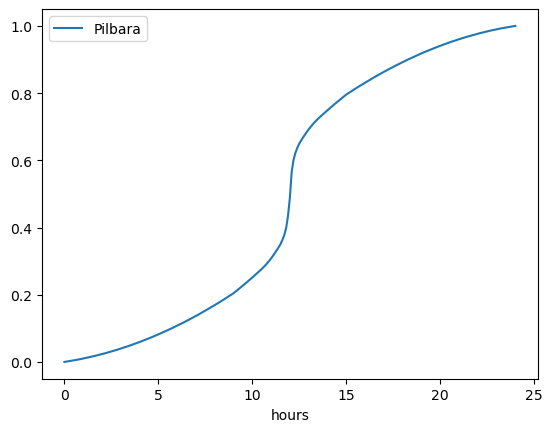

In [26]:
cdfs_df.plot()

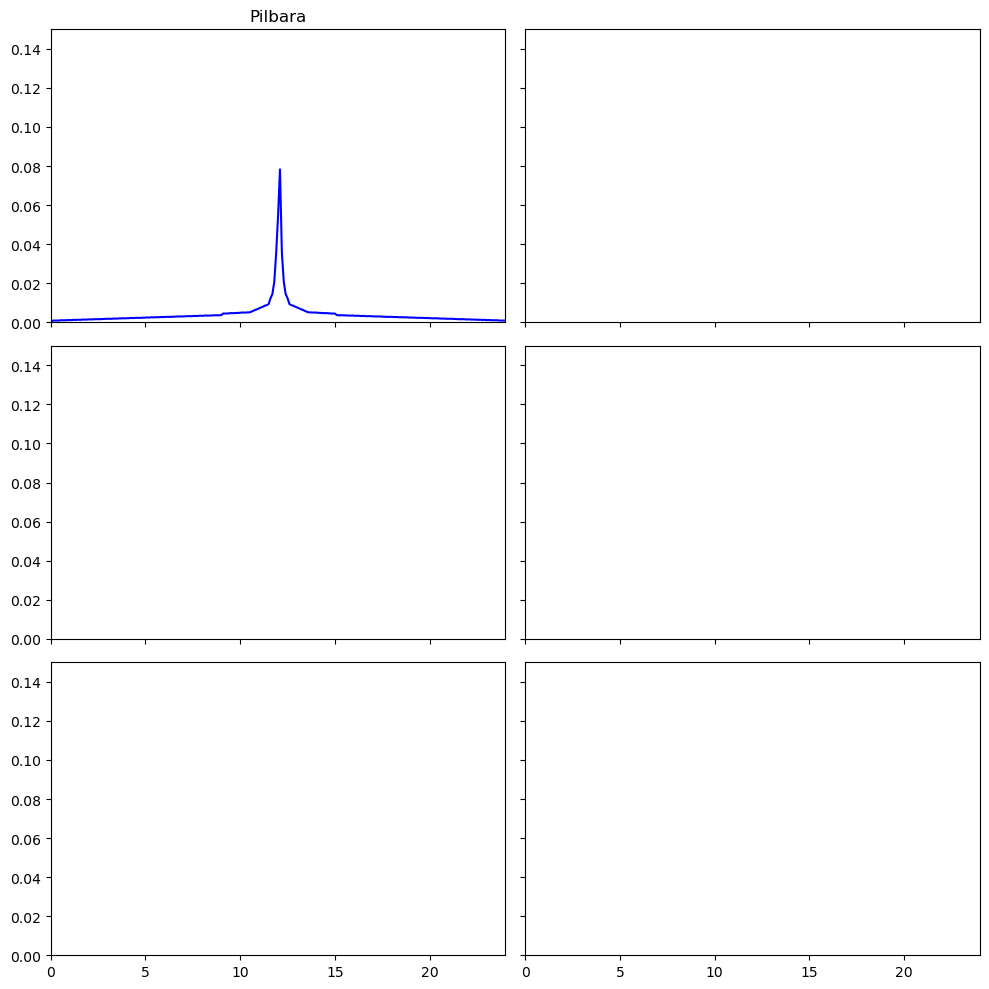

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)


# set the x and y axis range for all subplots
x_range = [0, 24]
y_range = [0, 0.15]

# loop through the columns of the DataFrame and plot each one in a subplot
for i, col in enumerate(pdfs_df.columns[:72]):
    row_idx = i // 2
    col_idx = i % 2
    ax = axs[row_idx, col_idx]
    ax.plot(pdfs_df[col], color='b')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title(col)

# adjust the spacing between subplots and save the figure
plt.tight_layout()
# plt.savefig('subplot.png')
plt.show()


# # pdf_df.plot(kind='bar', y=col_name, rot=0)
# pdfs_df[['Waikato_Region','Northland_Region_big', 'Auckland_Region']].plot()
# pdfs_df[['Taranaki_Region','Manawatu-Wanganui_Region', 'Wellington_Region']].plot()
# pdfs_df[['Bay_of_Plenty_Region','Gisborne_Region',"Hawke's_Bay_Region"]].plot()
# pdfs_df[['West_Coast_Region','Canterbury_Region','Otago_Region','Southland_Region']].plot()
# pdfs_df[['Tasman_Region','Nelson_Region','Marlborough_Region']].plot()
# cdfs_df.plot()

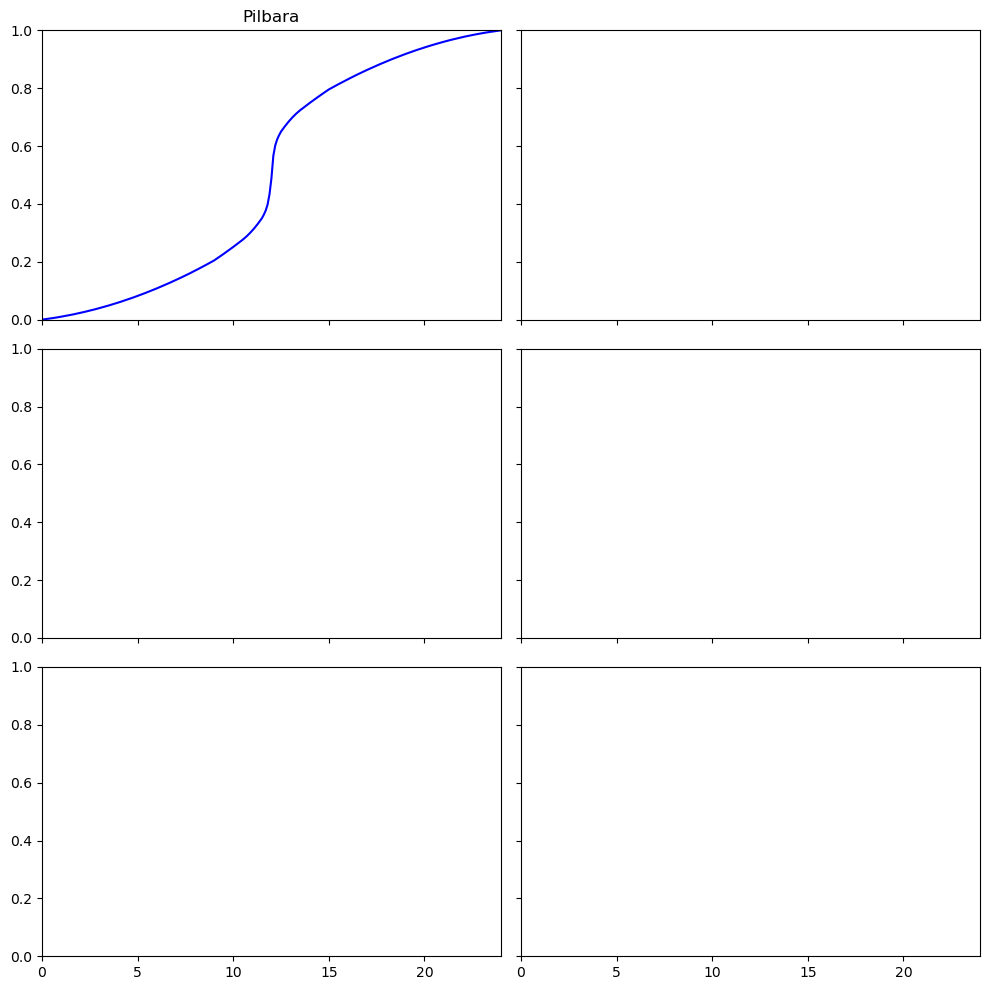

In [28]:

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)


# set the x and y axis range for all subplots
x_range = [0, 24]
y_range = [0, 1.0]

# loop through the columns of the DataFrame and plot each one in a subplot
for i, col in enumerate(cdfs_df.columns[:16]):
    row_idx = i // 2
    col_idx = i % 2
    ax = axs[row_idx, col_idx]
    ax.plot(cdfs_df[col], color='b')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title(col)

# adjust the spacing between subplots and save the figure
plt.tight_layout()
# plt.savefig('subplot.png')
plt.show()

# Old Code!

In [27]:
# # Compare regional curves

# REGC2017_curve = pd.read_csv(r'E:\Tuflow\Inputs\rainfall\old\temporal_curve\output\REGC2017_GV_clip_NZ_boundary_latlon\regional_pdfs_ARI100.0.csv', index_col=0)
# TA06_curve = pd.read_csv(r'E:\Tuflow\Inputs\rainfall\old\temporal_curve\output\TA06_LV2_V2_union_AU06\regional_pdfs_ARI100.0.csv', index_col=0)
# NZClimate_curve = pd.read_csv(r'E:\Tuflow\Cal_rainfall_timeseries\output\regional_pdfs_ARI' + str(ARI) + '_byNZClimate.csv', index_col=0)

In [32]:
REGC2017_curve

,shapefile_0,shapefile_1,shapefile_10,shapefile_11,shapefile_12,shapefile_13,shapefile_14,shapefile_15,shapefile_2,shapefile_3,shapefile_4,shapefile_5,shapefile_6,shapefile_7,shapefile_8,shapefile_9
hours,,,,,,,,,,,,,,,,
0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0.1,0.0009,0.0008,0.0015,0.0013,0.0013,0.0014,0.0013,0.0010,0.0009,0.0010,0.0014,0.0011,0.0012,0.0013,0.0013,0.0016
0.2,0.0010,0.0008,0.0015,0.0014,0.0013,0.0015,0.0013,0.0010,0.0009,0.0011,0.0015,0.0012,0.0012,0.0013,0.0013,0.0016
0.3,0.0010,0.0008,0.0016,0.0014,0.0013,0.0015,0.0014,0.0010,0.0010,0.0011,0.0014,0.0011,0.0013,0.0014,0.0014,0.0016
0.4,0.0010,0.0009,0.0015,0.0015,0.0014,0.0016,0.0014,0.0011,0.0010,0.0012,0.0016,0.0012,0.0013,0.0014,0.0014,0.0017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23.6,0.0010,0.0009,0.0017,0.0014,0.0014,0.0015,0.0014,0.0011,0.0010,0.0011,0.0015,0.0013,0.0013,0.0014,0.0014,0.0017
23.7,0.0010,0.0009,0.0015,0.0015,0.0014,0.0016,0.0014,0.0011,0.0010,0.0012,0.0016,0.0012,0.0013,0.0014,0.0014,0.0017
23.8,0.0010,0.0008,0.0016,0.0014,0.0013,0.0015,0.0014,0.0010,0.0010,0.0011,0.0014,0.0011,0.0013,0.0014,0.0014,0.0016


In [31]:
TA06_curve

,shapefile_10,shapefile_11,shapefile_12,shapefile_13,shapefile_14,shapefile_15,shapefile_16,shapefile_17,shapefile_18,shapefile_19,...,shapefile_81,shapefile_82,shapefile_9,shapefile_91,shapefile_92,shapefile_merge_0_76,shapefile_merge_1_77_87,shapefile_merge_2_83_84_85_88,shapefile_merge_79_80,shapefile_merge_86_89_90
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0.1,0.0013,0.0015,0.0009,0.0015,0.0006,0.0009,0.0010,0.0008,0.0009,0.0012,...,0.0013,0.0012,0.0015,0.0009,0.0009,0.0017,0.0013,0.0016,0.0015,0.0011
0.2,0.0013,0.0015,0.0009,0.0016,0.0006,0.0010,0.0010,0.0008,0.0010,0.0012,...,0.0013,0.0012,0.0015,0.0010,0.0010,0.0017,0.0013,0.0016,0.0014,0.0011
0.3,0.0014,0.0016,0.0010,0.0016,0.0007,0.0010,0.0011,0.0009,0.0010,0.0013,...,0.0014,0.0013,0.0015,0.0010,0.0010,0.0018,0.0013,0.0016,0.0016,0.0012
0.4,0.0014,0.0016,0.0009,0.0016,0.0007,0.0010,0.0011,0.0009,0.0010,0.0013,...,0.0013,0.0013,0.0015,0.0010,0.0010,0.0018,0.0014,0.0017,0.0015,0.0012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23.6,0.0014,0.0016,0.0011,0.0017,0.0007,0.0011,0.0011,0.0009,0.0011,0.0013,...,0.0015,0.0013,0.0016,0.0010,0.0010,0.0018,0.0013,0.0017,0.0016,0.0012
23.7,0.0014,0.0016,0.0009,0.0016,0.0007,0.0010,0.0011,0.0009,0.0010,0.0013,...,0.0013,0.0013,0.0015,0.0010,0.0010,0.0018,0.0014,0.0017,0.0015,0.0012
23.8,0.0014,0.0016,0.0010,0.0016,0.0007,0.0010,0.0011,0.0009,0.0010,0.0013,...,0.0014,0.0013,0.0015,0.0010,0.0010,0.0018,0.0013,0.0016,0.0016,0.0012


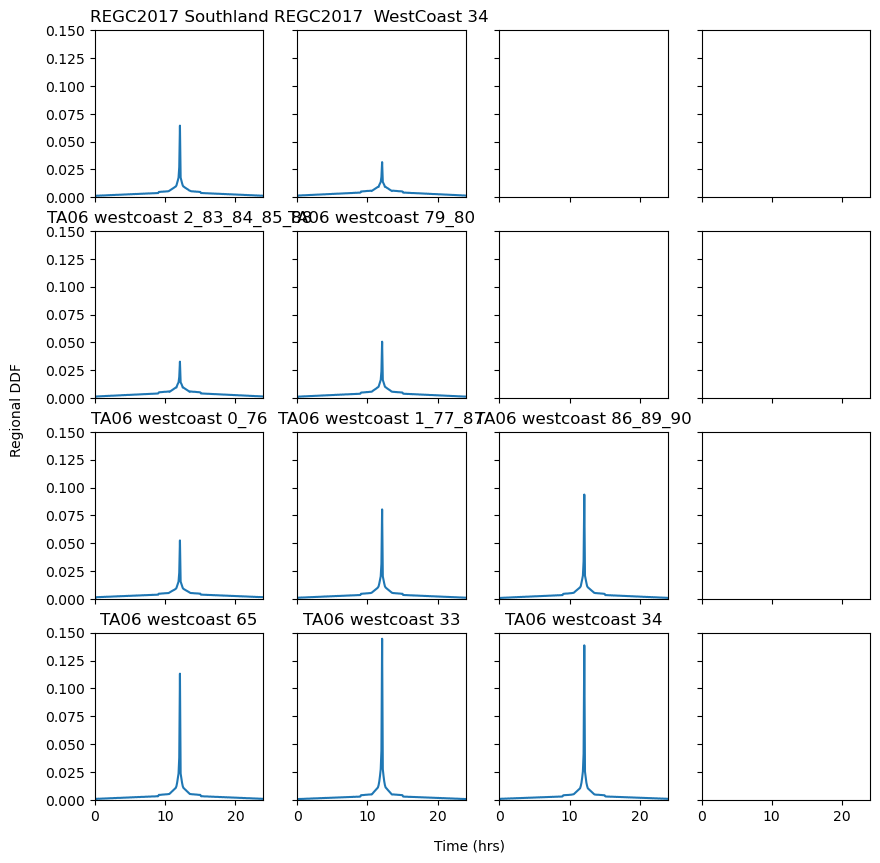

In [54]:
# Southland Westcost

def plot_once(df, label, row, col):
    ax = axs[row, col]
    ax.plot(df)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title(label)
    

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), sharex=True, sharey=True)


# set the x and y axis range for all subplots
x_range = [0, 24.0]
y_range = [0, 0.15]

plot_once(REGC2017_curve['shapefile_13'], 'REGC2017 Southland', 0, 0)
plot_once(TA06_curve['shapefile_8'], 'REGC2017  WestCoast 34', 0, 1)
plot_once(TA06_curve['shapefile_merge_2_83_84_85_88'], 'TA06 westcoast 2_83_84_85_88', 1, 0)
plot_once(TA06_curve['shapefile_merge_79_80'], 'TA06 westcoast 79_80', 1, 1)
plot_once(TA06_curve['shapefile_merge_0_76'], 'TA06 westcoast 0_76', 2, 0)
plot_once(TA06_curve['shapefile_merge_1_77_87'], 'TA06 westcoast 1_77_87', 2, 1)
plot_once(TA06_curve['shapefile_merge_86_89_90'], 'TA06 westcoast 86_89_90', 2, 2)
plot_once(TA06_curve['shapefile_65'], 'TA06 westcoast 65', 3, 0)
plot_once(TA06_curve['shapefile_33'], 'TA06 westcoast 33', 3, 1)
plot_once(TA06_curve['shapefile_34'], 'TA06 westcoast 34', 3, 2)

fig.text(0.5, 0.06, 'Time (hrs)', ha='center')
fig.text(0.04, 0.5, 'Regional DDF', va='center', rotation='vertical')


# adjust the spacing between subplots and save the figure
# plt.tight_layout()
plt.savefig('Southland.png', dpi=300)
plt.show()

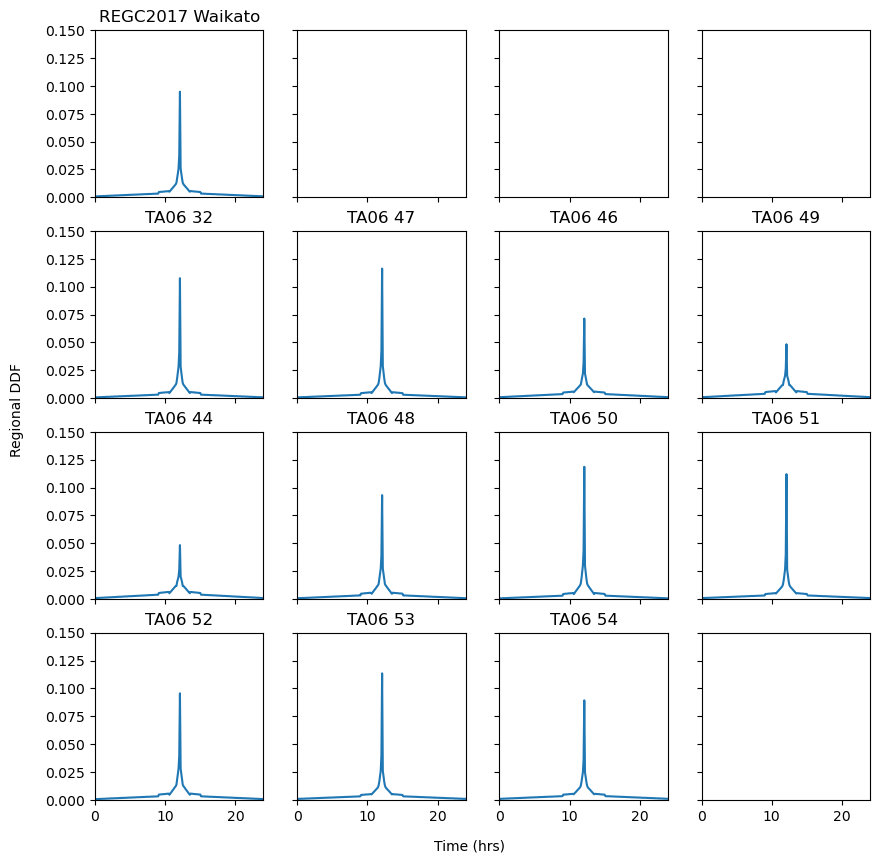

In [55]:
# Waikato

def plot_once(df, label, row, col):
    ax = axs[row, col]
    ax.plot(df)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title(label)
    

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), sharex=True, sharey=True)

# set the x and y axis range for all subplots
x_range = [0, 24.0]
y_range = [0, 0.15]

plot_once(REGC2017_curve['shapefile_2'], 'REGC2017 Waikato', 0, 0)
plot_once(TA06_curve['shapefile_32'], 'TA06 32', 1, 0)
plot_once(TA06_curve['shapefile_47'], 'TA06 47', 1, 1)
plot_once(TA06_curve['shapefile_46'], 'TA06 46', 1, 2)
plot_once(TA06_curve['shapefile_44'], 'TA06 49', 1, 3)
plot_once(TA06_curve['shapefile_44'], 'TA06 44', 2, 0)
plot_once(TA06_curve['shapefile_48'], 'TA06 48', 2, 1)
plot_once(TA06_curve['shapefile_50'], 'TA06 50', 2, 2)
plot_once(TA06_curve['shapefile_51'], 'TA06 51', 2, 3)
plot_once(TA06_curve['shapefile_52'], 'TA06 52', 3, 0)
plot_once(TA06_curve['shapefile_53'], 'TA06 53', 3, 1)
plot_once(TA06_curve['shapefile_54'], 'TA06 54', 3, 2)

fig.text(0.5, 0.06, 'Time (hrs)', ha='center')
fig.text(0.04, 0.5, 'Regional DDF', va='center', rotation='vertical')

# adjust the spacing between subplots and save the figure
# plt.tight_layout()
plt.savefig('Waikato.png', dpi=300)
plt.show()